In [637]:
# Multilayer Perceptron to Predict International Airline Passengers (t+1, given t)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
from sklearn import datasets, linear_model
#from keras.models import Sequential
#from keras.layers import Dense

%matplotlib inline
import seaborn as sns; sns.set()
# fix random seed for reproducibility
numpy.random.seed(7)
import warnings
warnings.filterwarnings('ignore')

def prep (a):
    return a.reshape(a.shape[0], 1)
def unprep (a):
    return np.squeeze(a)

In [536]:
#df = pandas.read_csv('/Users/david/notebooks/data/futs1.csv', usecols=[0:2], engine='python', skipfooter=3)
df = pandas.read_csv('/Users/david/notebooks/data/futs1.csv', header=3)
df = df.drop(df.columns[3:], axis=1) 
df["Date"] = pd.to_datetime(df["Date"], infer_datetime_format=True)
df2 = df.copy()
df2["CHG"] = df2["OPEN"] - df2["OPEN"].shift(1)
df2["PREVVOLUME"] = df2["VOLUME"].shift(1)
df2 = df2.dropna()
#df.loc[3:]
#df.head()
print(df.head())
print(df2.dtypes)

                 Date        OPEN  VOLUME
0 2016-09-01 09:00:00  130.671875     871
1 2016-09-01 09:01:00  130.656250      14
2 2016-09-01 09:02:00  130.656250     103
3 2016-09-01 09:03:00  130.656250     395
4 2016-09-01 09:04:00  130.656250     186
Date          datetime64[ns]
OPEN                 float64
VOLUME                 int64
CHG                  float64
PREVVOLUME           float64
dtype: object


[[ 1.    -0.484]
 [-0.484  1.   ]]
(12577,) (12577,)
Coefficients: 
 [[-126812.23]]
Mean squared error: 2802143.78
Variance score: 0.23


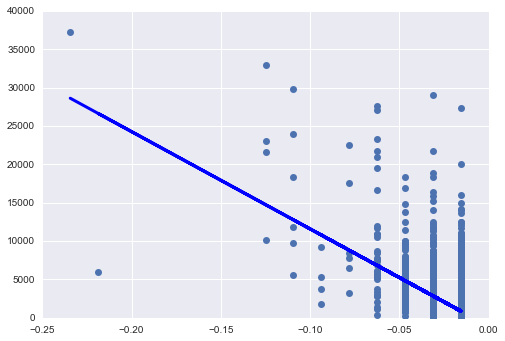

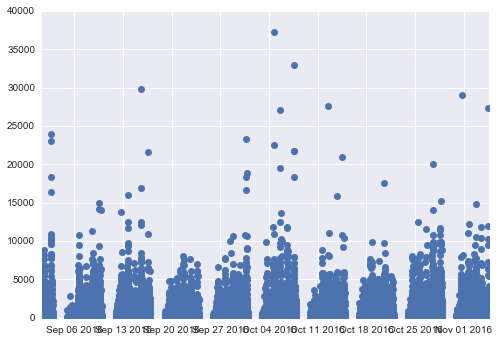

(57120,)


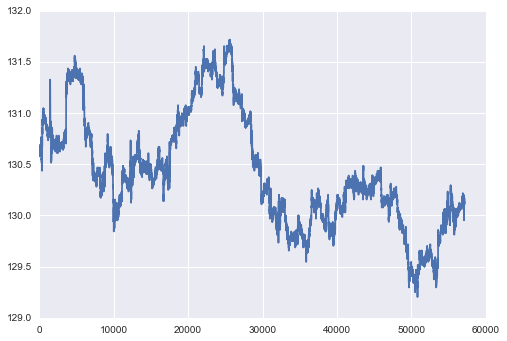

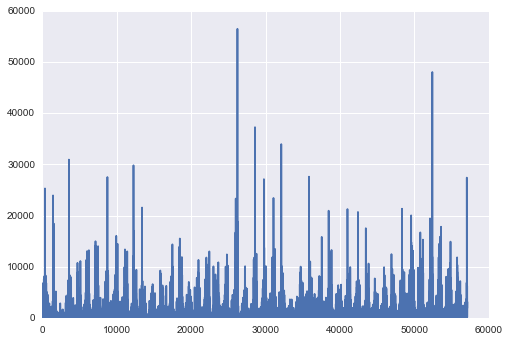

In [514]:
plt.plot(df["OPEN"])
plt.figure()
plt.plot(df["VOLUME"])
print(df["OPEN"].shape)

In [405]:
df["OPEN"][:50].values


array([ 130.672,  130.656,  130.656,  130.656,  130.656,  130.656,
        130.656,  130.656,  130.672,  130.656,  130.672,  130.656,
        130.656,  130.672,  130.656,  130.672,  130.656,  130.672,
        130.672,  130.672,  130.688,  130.672,  130.672,  130.672,
        130.672,  130.672,  130.672,  130.672,  130.672,  130.672,
        130.672,  130.625,  130.625,  130.578,  130.594,  130.594,
        130.594,  130.609,  130.625,  130.625,  130.625,  130.625,
        130.625,  130.641,  130.641,  130.609,  130.625,  130.625,
        130.609,  130.609])

In [406]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

In [407]:
dt = .1
x = np.array([0., 0.]) 
kf = pos_vel_filter(x, P=500, R=5, Q=0.1, dt=dt)

In [640]:

def fin_data(count=50, start=0,win=1, offset=0):
    #ret = np.array(df["OPEN"][:50])
    ret = df["OPEN"][start:count+start].values - df["OPEN"][start]
    
    l = np.arange(len(ret))
    print(l, ret)
    lr = linear_model.LinearRegression()
    lr.fit(prep(l), prep(ret))
    print(lr.coef_)
    m = unprep(lr.predict(prep(l)))
    print(m.shape)
    #m = pd.rolling_mean(df["OPEN"].shift(offset).values, win)[win+start:count+win+start] - df["OPEN"][start]
    #m = movingaverage(df["OPEN"].shift(i-1).values, i)[i+start:count+i+start] - df["OPEN"][start]
    #print(movingaverage(df["OPEN"].shift(i).values, i)[i+start:count+i+start])
    #print(ret)
    #print(m)
    #ret = ret.reshape(ret.shape[0], 1)
    return m, ret

[   0    1    2 ..., 4997 4998 4999] [ 0.    -0.016 -0.016 ...,  0.734  0.734  0.75 ]
[[ 0.]]
(5000,)
(5000,)
(5000,)


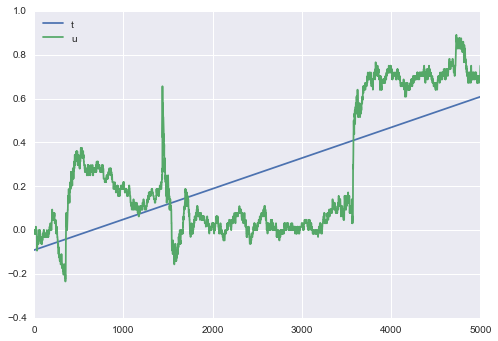

In [641]:
t, u = fin_data(start=0, count=5000, win=3, offset=0)
#y1.reshape(y1.shape[0], 1)
#t
#df["OPEN"][0:50].values
print(u.shape)
print(t.shape)
plt.plot(t, '-', label ='t')
plt.plot(u, '-', label ='u')
plt.legend(loc="best")

In [620]:
from code.book_plots import interactive_plot
import code.book_plots as bp
from code.mkf_internal import plot_covariance
def plot_track(ps, actual, zs, cov, std_scale=1,
               plot_P=True, y_lim=None, dt=1.,
               xlabel='time', ylabel='position',
               title='Kalman Filter'):

    with interactive_plot():
        count = len(zs)
        zs = np.asarray(zs)

        cov = np.asarray(cov)
        std = std_scale*np.sqrt(cov[:,0,0])
        std_top = np.minimum(actual+std, [count + 10])
        std_btm = np.maximum(actual-std, [-50])
        
        print("stds", std_top.shape, std_btm.shape)
        std_top = actual + std
        std_btm = actual - std

        bp.plot_track(actual,c='k')
        bp.plot_measurements(range(1, count + 1), zs)
        bp.plot_filter(range(1, count + 1), ps)

        plt.plot(std_top, linestyle=':', color='k', lw=1, alpha=0.4)
        plt.plot(std_btm, linestyle=':', color='k', lw=1, alpha=0.4)
        plt.fill_between(range(len(std_top)), std_top, std_btm,
                         facecolor='yellow', alpha=0.2, interpolate=True)
        plt.legend(loc=4)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        #y_lim = ps.max().abs()
        #if y_lim is not None:
        #    plt.ylim(y_lim)
        #else:
        #    plt.ylim((-50, count + 10))

        plt.xlim((0,count))
        plt.title(title)
        plt.show()

    if plot_P:
        ax = plt.subplot(121)
        ax.set_title("$\sigma^2_x$ (pos variance)")
        plot_covariance(cov, (0, 0))
        ax = plt.subplot(122)
        ax.set_title("$\sigma^2_\dot{x}$ (vel variance)")
        plot_covariance(cov, (1, 1))
        plt.show()



In [614]:


def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0, 
        track=None, zs=None,
        do_plot=True, 
        **kwargs):
    """
    track is the actual position of the dog, zs are the 
    corresponding measurements. 
    """
    
    # Simulate dog if no data provided. 
    #if zs is None:
    #    track, zs = fin_data(count=count, start=start, offset=offset, win=win)
        #track, zs = compute_dog_data(R, Q, count)
    #print(zs)
    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
    #print(xs)
    #print(cov)
    #print(zs)
    #print(track)
    if do_plot:
        print(xs.shape, track.shape)
        plt.figure(figsize=(20,10))
        plot_track(xs[:, 0], track, zs, cov, 
                   dt=dt, **kwargs)
    return xs, cov

In [412]:
t1, t2 = fin_data(500)
np.std(t1)
np.std(t2)

0.14803859557983517

In [413]:
def plot_residual_limits(Ps, stds=1.):
    """ plots standand deviation given in Ps as a yellow shaded region. One std
    by default, use stds for a different choice (e.g. stds=3 for 3 standard
    deviations.
    """
    #Ps = np.diagonal(Ps)
    for s in stds:
        std = np.sqrt(Ps) * s
        #print(std)
        plt.plot(-std, color='k', ls=':', lw=2)
        plt.plot(std, color='k', ls=':', lw=2)
        plt.fill_between(range(len(std)), -std, std,
                 facecolor='#ffff00', alpha=0.3)

In [414]:
def plot_residuals(xs, filter_xs, Ps, title, y_label, stds=1):
    res = xs - filter_xs
    plt.figure()
    plt.plot(res)
    plot_residual_limits(Ps, [1,2,3])
    bp.set_labels(title, 'time (mins)', y_label)

In [430]:
def calc_e (x, y):
    #Predictor comparison
    res = x - y
    res_e = np.sqrt(np.mean(res**2))
    #print(res_e)
    return res_e, res

In [494]:
def run_kf(R, Q, count, start, do_plot=False):
    std = 0.20
    top_vel = 0.2
    #R = 0.005
    #Q = 0.001

    p1 = std**2
    p2 = (top_vel/3)**2
    #print(p1,p2)
    P = np.diag([p1, p2])
    xs_real, zs = fin_data(count=count, start=start, offset=0, win=2)
    #print(xs_real.shape, zs.shape)
    xs_kf, ps = run(track=xs_real, zs=zs, R=R, Q=Q, P=P, do_plot=do_plot)
    if do_plot :
        plot_residuals(xs_real, xs_kf[:, 0], ps[:, 0,0], 
                   title='First Order Position Residuals(1$\sigma$)',
                   y_label='price') 
    #simple_res_e = calc_e(zs, xs_real)
    kf_res_e, kf_res = calc_e(xs_kf[:,0], xs_real)
    return kf_res_e, kf_res
#print(ps)

[0.1]
[   0    1    2 ..., 4997 4998 4999] [ 0.    -0.016 -0.016 ...,  0.734  0.734  0.75 ]
[[ 0.]]
[   0    1    2 ..., 4997 4998 4999] [ 0.    -0.016 -0.016 ...,  0.734  0.734  0.75 ]
[[ 0.]]
0.0157952530009
['0.1:0.1']


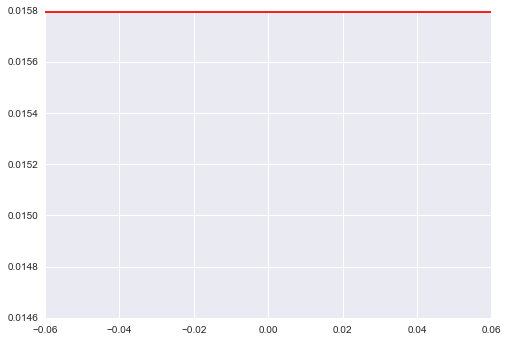

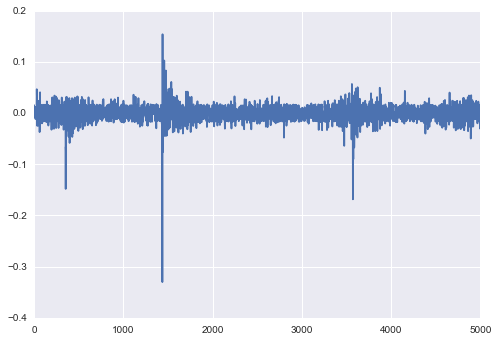

In [623]:

if True:
    count = 5000
    start = 0
else:
    count = 500
    start = 0

e_r =[]
e_res = []
R_ar = [0.1]
Q_ar = [0.1]
#R_ar = np.logspace(-6, 0, 7, base=10.0)
#Q_ar = np.logspace(-6, 0, 7, base=10.0)
print(R_ar)
label = []
#R_ar = [0.01]
for r in R_ar:
    for q in Q_ar:
        e1, e2 = run_kf(Q=q, R = r,count=count, start=start, do_plot=False) 
        #print(e2)
        e_r.append(e1)
        e_res.append(e2)
        label.append(str(r) +':'+ str(q))
        #plt.plot(e2)

xs_real, zs = fin_data(count=count, start=start, offset=0, win=3)
simple_res_e, no = calc_e(zs, xs_real)
print(simple_res_e)
print(label)
plt.figure()
plt.axhline(y=[simple_res_e], color='r', linestyle='-')
plt.plot(e_r, label = label)
#plt.plot(R_ar, e_r, linestyle='-')
plt.figure()
for e in e_res:
    plt.plot(e)


[0.01]
[   0    1    2 ..., 4997 4998 4999] [ 0.     0.     0.    ..., -0.062 -0.062 -0.062]
[[ 0.]]
(5000,)
(5000, 2) (5000,)
stds (5000,) (5000,)


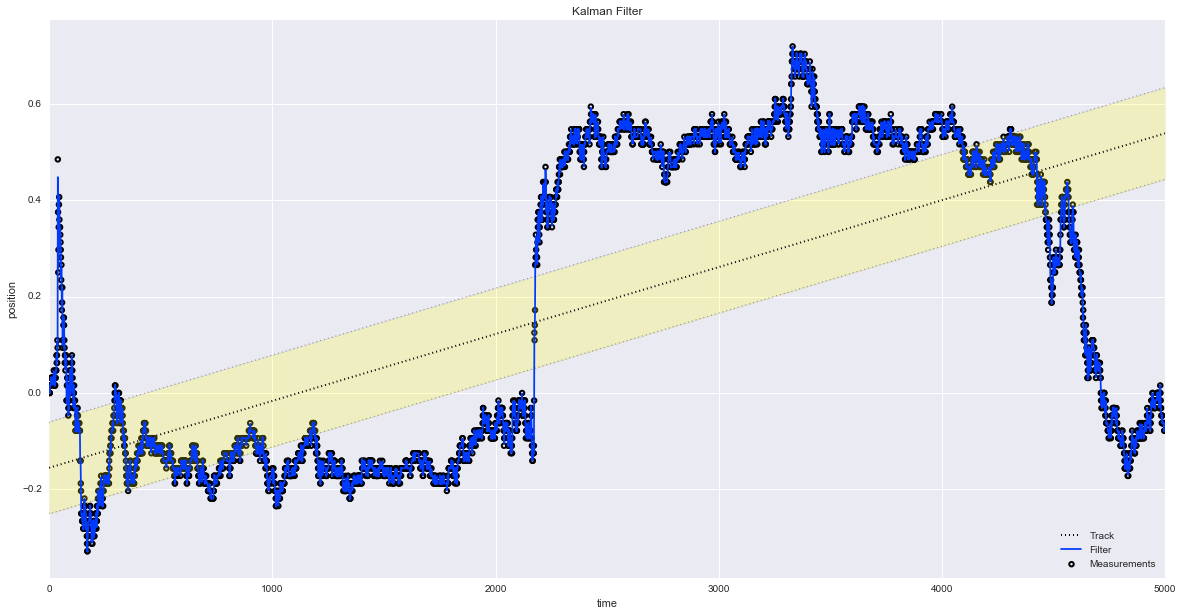

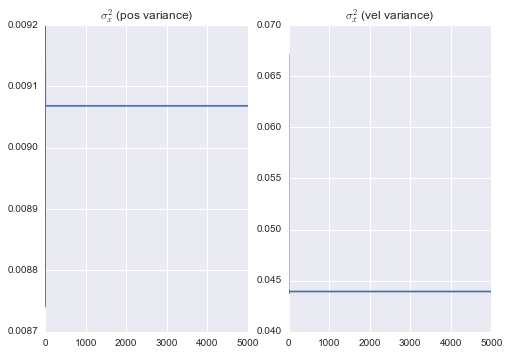

[   0    1    2 ..., 4997 4998 4999] [ 0.     0.     0.    ..., -0.062 -0.062 -0.062]
[[ 0.]]
(5000,)
0.250822289335
['0.01:0.1']


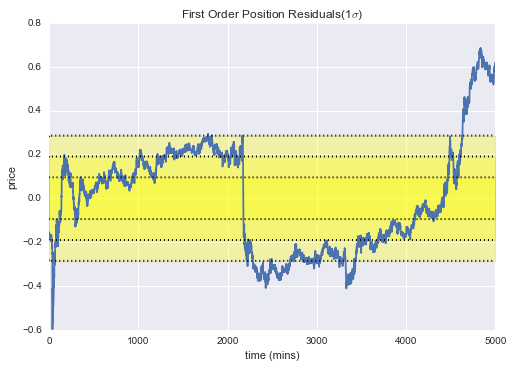

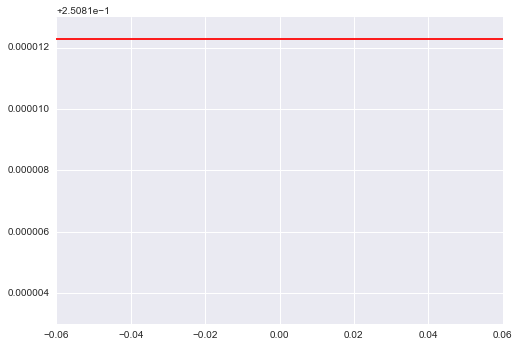

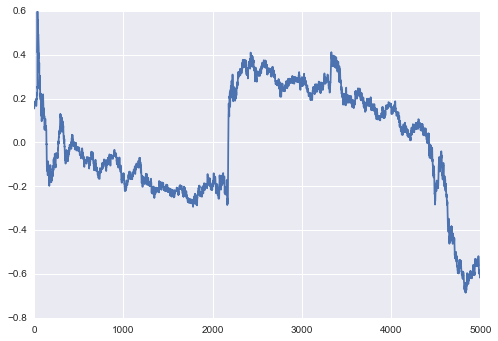

In [643]:

if True:
    count = 5000
    start = 1400
else:
    count = 500
    start = 0

e_r =[]
e_res = []
R_ar = [0.01]
Q_ar = [0.1]
#R_ar = np.logspace(-6, 0, 7, base=10.0)
#Q_ar = np.logspace(-6, 0, 7, base=10.0)
print(R_ar)
label = []
#R_ar = [0.01]
for r in R_ar:
    for q in Q_ar:
        e1, e2 = run_kf(Q=q, R = r,count=count, start=start, do_plot=True) 
        #print(e2)
        e_r.append(e1)
        e_res.append(e2)
        label.append(str(r) +':'+ str(q))
        #plt.plot(e2)

xs_real, zs = fin_data(count=count, start=start, offset=0, win=3)
simple_res_e, no = calc_e(zs, xs_real)
print(simple_res_e)
print(label)
plt.figure()
plt.axhline(y=[simple_res_e], color='r', linestyle='-')
plt.plot(e_r, label = label)
#plt.plot(R_ar, e_r, linestyle='-')
plt.figure()
for e in e_res:
    plt.plot(e)

In [ ]:
R_ar = np.linspace

In [418]:
simple_res_e = calc_e(zs, xs_real)
kf_res_e = calc_e(xs_kf[:,0], xs_real)
print('simple_res_e= ', simple_res_e)
print('kf_res_e= ', kf_res_e)

simple_res_e=  (0.03160819025145728, array([-0.005, -0.005, -0.01 ,  0.005, -0.026, -0.016, -0.016,  0.026,
        0.026,  0.021,  0.031, -0.005, -0.005, -0.01 ,  0.01 , -0.005,
        0.016,  0.   ,  0.   ,  0.   ,  0.005,  0.01 ,  0.016,  0.   ,
        0.   ,  0.005,  0.01 ,  0.016,  0.   , -0.005, -0.021, -0.031,
       -0.016,  0.021,  0.01 , -0.005,  0.016, -0.01 , -0.01 , -0.01 ,
        0.036,  0.005,  0.01 , -0.005,  0.021,  0.01 ,  0.01 , -0.005,
        0.   ,  0.021,  0.005, -0.016, -0.047, -0.099, -0.161, -0.068,
       -0.099, -0.099, -0.005,  0.016,  0.016,  0.021,  0.026, -0.042,
       -0.01 , -0.005,  0.042,  0.026,  0.016,  0.021, -0.021, -0.016,
       -0.031, -0.036, -0.036, -0.031, -0.01 , -0.021, -0.042, -0.021,
       -0.031,  0.005,  0.016,  0.021, -0.005, -0.042, -0.031,  0.   ,
        0.021, -0.016,  0.005,  0.01 ,  0.016,  0.01 ,  0.021,  0.031,
       -0.016, -0.036, -0.057, -0.01 ]))
kf_res_e=  (0.034759542572838462, array([ -5.208e-03,  -5.208e-03,  -1